In [1]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import yfinance as yf
import datetime



In [2]:
msft = yf.Ticker("QCOM")
print(msft)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



df = msft.history(period="5y")
print(df)

df = df[['Close']]
df


yfinance.Ticker object <QCOM>
                                 Open        High         Low       Close  \
Date                                                                        
2019-07-31 00:00:00-04:00   66.627310   67.027979   64.784219   65.140373   
2019-08-01 00:00:00-04:00   61.329524   65.630072   60.768585   63.395210   
2019-08-02 00:00:00-04:00   62.718522   63.689036   62.335658   63.350693   
2019-08-05 00:00:00-04:00   62.300039   63.074667   61.044597   61.258293   
2019-08-06 00:00:00-04:00   61.899352   62.264412   59.993936   60.697338   
...                               ...         ...         ...         ...   
2024-07-25 00:00:00-04:00  179.619995  180.240005  173.270004  175.389999   
2024-07-26 00:00:00-04:00  179.009995  181.300003  177.570007  180.050003   
2024-07-29 00:00:00-04:00  181.500000  182.639999  177.850006  178.639999   
2024-07-30 00:00:00-04:00  179.339996  179.399994  166.770004  166.940002   
2024-07-31 00:00:00-04:00  175.630005  176.259

,Close
Date,
2019-07-31 00:00:00-04:00,65.140373
2019-08-01 00:00:00-04:00,63.395210
2019-08-02 00:00:00-04:00,63.350693
2019-08-05 00:00:00-04:00,61.258293
2019-08-06 00:00:00-04:00,60.697338
...,...
2024-07-25 00:00:00-04:00,175.389999
2024-07-26 00:00:00-04:00,180.050003
2024-07-29 00:00:00-04:00,178.639999


In [3]:
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df


lookback = 7
shifted_df = prepare_dataframe_for_lstm(df, lookback)
shifted_df

shifted_df_np = shifted_df.to_numpy()
shifted_df_np
print(shifted_df_np.shape)

#Day 1     #Todays close   #Close day -1      Close day 2   close day -3 


(1252, 8)


In [4]:
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_np = scaler.fit_transform(shifted_df_np)

shifted_df_np

X = shifted_df_np[:, 1:]

y = shifted_df_np[:, 0]

X.shape, y.shape
print(X)

X = dc(np.flip(X, axis=1))
X
split_index = int(len(X) * .95)
split_index

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape



[[-0.90764045 -0.92694654 -0.9397135  ... -0.90878216 -0.9082632
  -0.88791906]
 [-0.90514948 -0.90764045 -0.92694654 ... -0.9331742  -0.90878216
  -0.9082632 ]
 [-0.92279459 -0.90514948 -0.90764045 ... -0.9397135  -0.9331742
  -0.90878216]
 ...
 [ 0.4516338   0.39731005  0.46352444 ...  0.62556288  0.52344371
   0.5846453 ]
 [ 0.43519676  0.4516338   0.39731005 ...  0.60667787  0.62556288
   0.52344371]
 [ 0.29880467  0.43519676  0.4516338  ...  0.46352444  0.60667787
   0.62556288]]


(torch.Size([1189, 7, 1]),
 torch.Size([63, 7, 1]),
 torch.Size([1189, 1]),
 torch.Size([63, 1]))

In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]


train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_dataset


batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [6]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break


class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size,
                         self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size,
                         self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


model = LSTM(1, 16, 2)
model.to(device)
model



torch.Size([16, 7, 1]) torch.Size([16, 1])


LSTM(
  (lstm): LSTM(1, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [7]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()


def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()


learning_rate = 0.003
num_epochs = 30
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()


Epoch: 1

Val Loss: 0.085
***************************************************

Epoch: 2

Val Loss: 0.066
***************************************************

Epoch: 3

Val Loss: 0.043
***************************************************

Epoch: 4

Val Loss: 0.013
***************************************************

Epoch: 5

Val Loss: 0.017
***************************************************

Epoch: 6

Val Loss: 0.016
***************************************************

Epoch: 7

Val Loss: 0.013
***************************************************

Epoch: 8

Val Loss: 0.012
***************************************************

Epoch: 9

Val Loss: 0.010
***************************************************

Epoch: 10

Val Loss: 0.010
***************************************************

Epoch: 11

Val Loss: 0.005
***************************************************

Epoch: 12

Val Loss: 0.005
***************************************************

Epoch: 13

Val Loss: 0.005
**********************

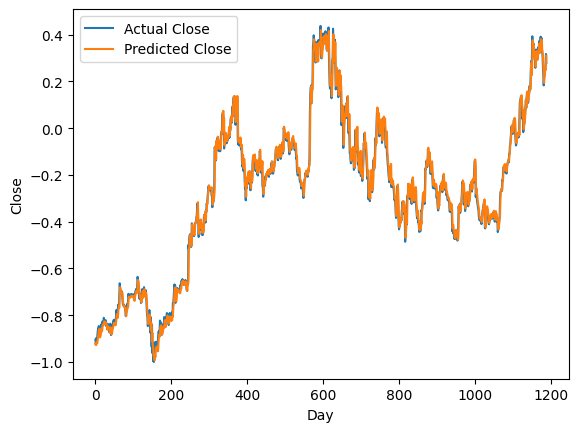

torch.Size([1189, 1])
(1189, 1)
(1189,)


In [8]:
plt.plot(y_train, label='Actual Close')

plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

print(y_train.shape)
print(predicted.shape)
train_predictions = predicted.flatten()
print(train_predictions.shape)


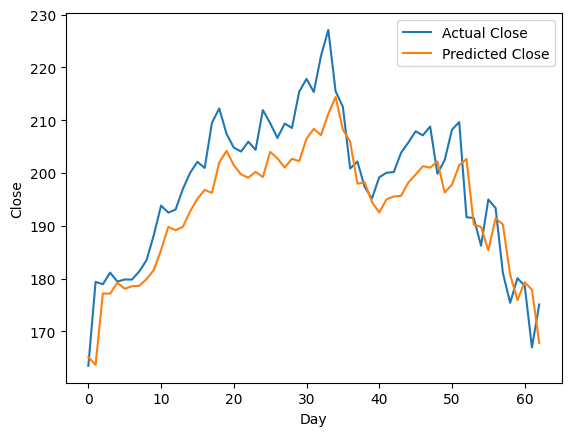

array([165.09566572, 163.65067274, 177.16400129, 177.13707106,
       179.1967297 , 178.0579498 , 178.54067933, 178.60435677,
       179.88417906, 181.60437471, 185.37497956, 189.78174005,
       189.14825851, 189.78242519, 192.7233623 , 195.10240001,
       196.7862984 , 196.22169423, 201.97379001, 204.16719989,
       201.46739746, 199.72187196, 199.10265572, 200.21953149,
       199.21294336, 203.98318776, 202.78043387, 200.99397872,
       202.67673179, 202.22940985, 206.49775093, 208.3408838 ,
       207.1570276 , 211.20907811, 214.3796354 , 208.18359226,
       205.94125599, 197.95900824, 198.21734309, 194.47803498,
       192.51026736, 194.99304295, 195.53636166, 195.65539765,
       198.19163999, 199.67354379, 201.27942786, 201.000416  ,
       202.16958252, 196.28372016, 197.78119819, 201.47095101,
       202.63218213, 190.22848422, 189.76581813, 185.33752164,
       191.43202551, 190.2429796 , 180.73225364, 175.91010707,
       179.28924451, 177.87403481, 167.81469818])

In [9]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train


test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


test_predictions



Test Results:
                        Date      Actual   Predicted
0  2024-05-01 00:00:00-04:00  163.440201  165.095666
1  2024-05-02 00:00:00-04:00  179.364945  163.650673
2  2024-05-03 00:00:00-04:00  178.906814  177.164001
3  2024-05-06 00:00:00-04:00  181.107804  177.137071
4  2024-05-07 00:00:00-04:00  179.414718  179.196730
..                       ...         ...         ...
58 2024-07-25 00:00:00-04:00  175.389999  180.732254
59 2024-07-26 00:00:00-04:00  180.050004  175.910107
60 2024-07-29 00:00:00-04:00  178.640000  179.289245
61 2024-07-30 00:00:00-04:00  166.940003  177.874035
62 2024-07-31 00:00:00-04:00  175.070006  167.814698

[63 rows x 3 columns]
                        Date      Actual   Predicted   Signal
0  2024-05-01 00:00:00-04:00  163.440201  165.095666      Buy
1  2024-05-02 00:00:00-04:00  179.364945  163.650673     Sell
2  2024-05-03 00:00:00-04:00  178.906814  177.164001  Neutral
3  2024-05-06 00:00:00-04:00  181.107804  177.137071     Sell
4  2024-05-07 00:

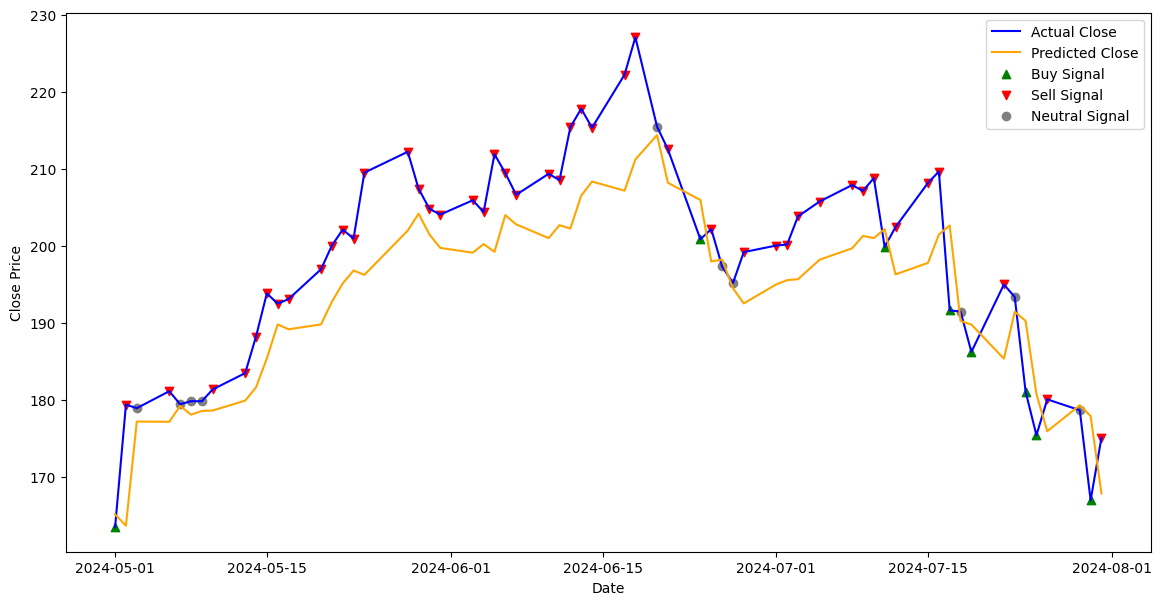

In [10]:
test_dates = df.index[-len(new_y_test):]

# Create dataframe with dates, actual and predicted values
test_results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': new_y_test,
    'Predicted': test_predictions
})
print("Test Results:")
print(test_results_df)


def generate_trading_signals(test_results_df, neutral_threshold=0.01):
    test_results_df['Signal'] = 'Neutral'

    test_results_df.loc[test_results_df['Predicted'] >
                        test_results_df['Actual'] * (1 + neutral_threshold), 'Signal'] = 'Buy'
    test_results_df.loc[test_results_df['Predicted'] <
                        test_results_df['Actual'] * (1 - neutral_threshold), 'Signal'] = 'Sell'

    return test_results_df


test_results_df_with_signals = generate_trading_signals(test_results_df)
print(test_results_df_with_signals)

# Visualization of trading signals
plt.figure(figsize=(14, 7))
plt.plot(test_results_df['Date'], test_results_df['Actual'],
         label='Actual Close', color='b')
plt.plot(test_results_df['Date'], test_results_df['Predicted'],
         label='Predicted Close', color='orange')
buy_signals = test_results_df_with_signals[test_results_df_with_signals['Signal'] == 'Buy']
sell_signals = test_results_df_with_signals[test_results_df_with_signals['Signal'] == 'Sell']
neutral_signals = test_results_df_with_signals[test_results_df_with_signals['Signal'] == 'Neutral']
plt.scatter(buy_signals['Date'], buy_signals['Actual'],
            label='Buy Signal', marker='^', color='g')
plt.scatter(sell_signals['Date'], sell_signals['Actual'],
            label='Sell Signal', marker='v', color='r')
plt.scatter(neutral_signals['Date'], neutral_signals['Actual'],
            label='Neutral Signal', marker='o', color='gray')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()
